In [1]:
import sys
import os

import joblib

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

In [4]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, encode_labels, train_val_split, \
    get_dimensions, get_device, metrics_c, plot_history, read_target_tensors

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
path_features = os.path.abspath(os.path.join(os.getcwd(), "../../../data/features2"))
path_targets = os.path.abspath(os.path.join(os.getcwd(), "../../../data/targets/classification"))

In [7]:
target = "HistoricalPeriod"

## Data

### Read Features and Targets

In [8]:
X = read_features(path_features, f_type="tensors")
print_info_features(X)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_val_tfidf
Loaded X_val_bert
Loaded X_val_cannyhog
Loaded X_val_resnet
Loaded X_val_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<

In [9]:
y = read_target_tensors(path_targets)
print_info_targets(y)

Loaded y_train
Loaded y_val
Loaded y_test
{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1528])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


### Load Target Encoder

In [10]:
path_encoder = os.path.join(path_targets, "y_encoder.pkl")
y_encoder = joblib.load(path_encoder)

### Dimensions

In [11]:
X_dim, y_dim = get_dimensions(X, y, y_encoder)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


### Torch Datasets and Dataloaders

In [12]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## MLP: Pottery Chronology Predictor - Historical Period Classifier


### Initialize Models

In [13]:
hidden_size = 512

models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="periods")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="periods")
             for ft_txt, ft_img in feature_type_combos
         }

In [14]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 512]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 512]                  154,112                   154,112
│    │    └─ReLU: 3-2                    [1, 512]                  [1, 512]                  --                        --
│    │    └─Dropout: 3-3                 [1, 512]                  [1, 512]                  --                        --
├─Sequential: 1-2                        [1, 512]                  [1, 4]                    -- 

### Train Models

In [15]:
criterion = nn.CrossEntropyLoss()
metrics = {m: metrics_c[m] for m in metrics_c.keys()}



** FEATURE SET: TFIDF **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1206.30it/s, loss=1.3217]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.4999, val_loss: 0.5399, accuracy: [0.78], precision: [0.38], recall: [0.40], f1: [0.39], 


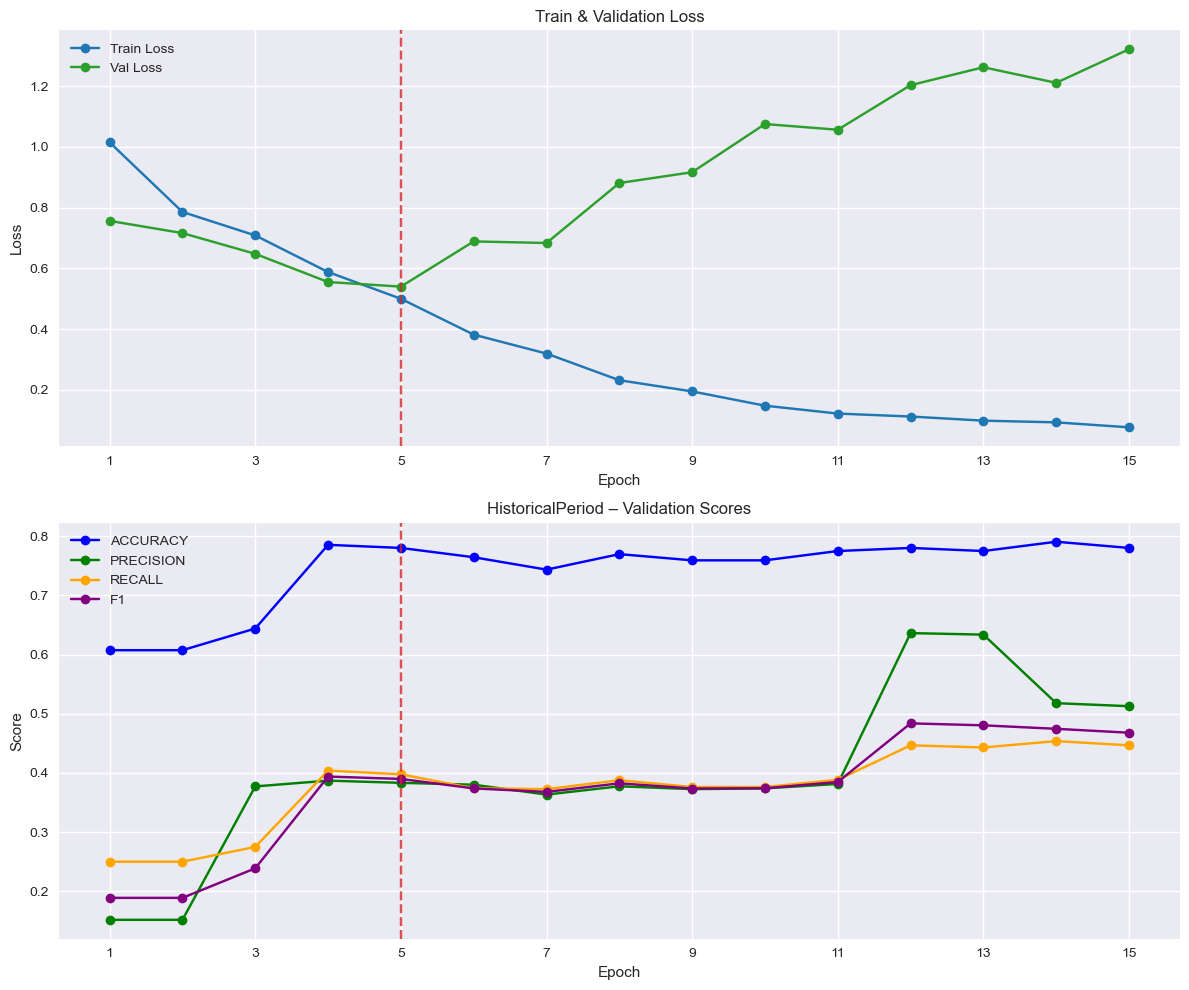



** FEATURE SET: BERT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1022.17it/s, loss=0.7621]


** Early stop | ran: 20/50 epochs | final: epoch 10 | train_loss: 0.6584, val_loss: 0.6834, accuracy: [0.71], precision: [0.35], recall: [0.34], f1: [0.34], 


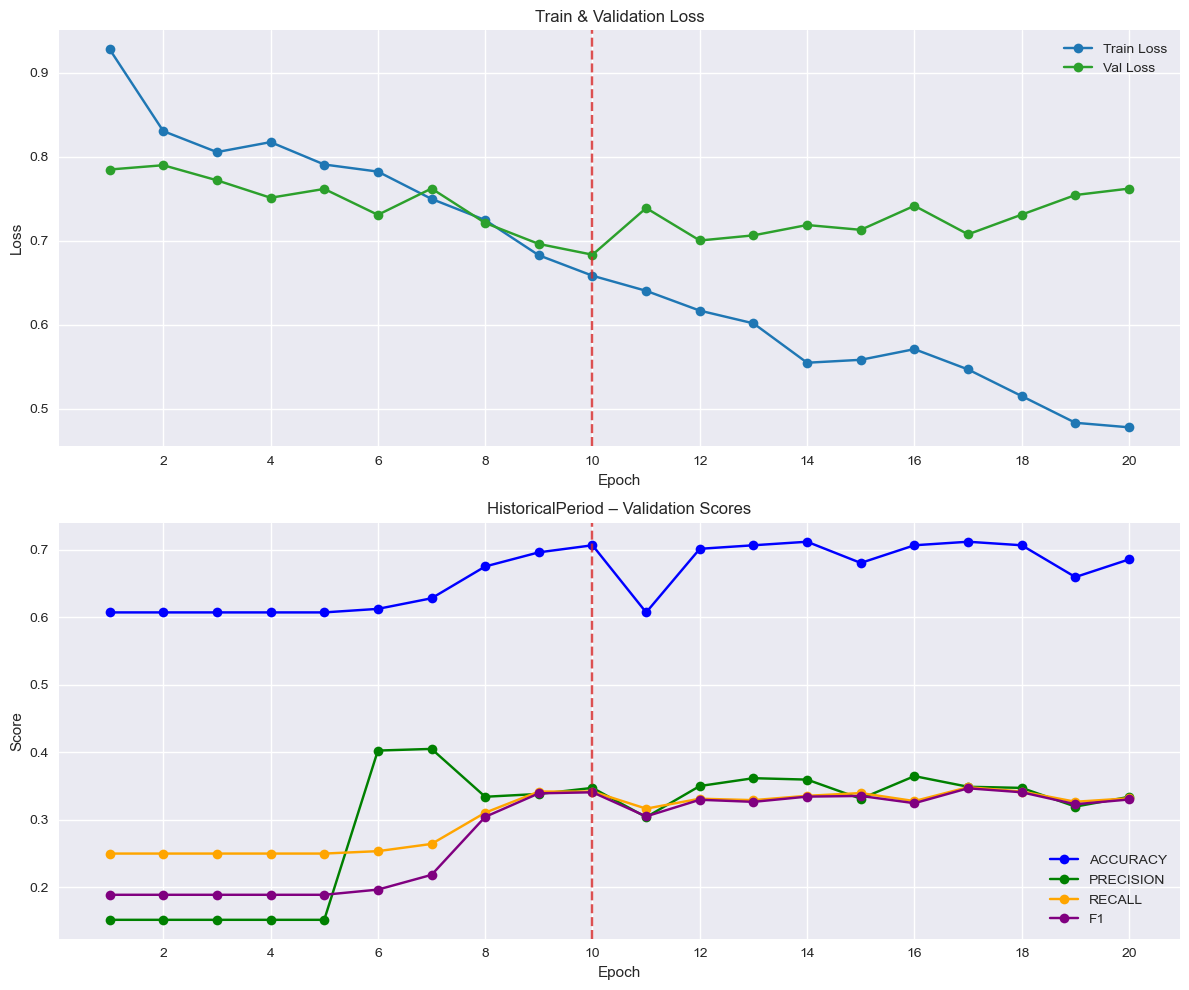



** FEATURE SET: CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 948.37it/s, loss=0.7828]


** Early stop | ran: 30/50 epochs | final: epoch 20 | train_loss: 0.7922, val_loss: 0.7786, accuracy: [0.61], precision: [0.15], recall: [0.25], f1: [0.19], 


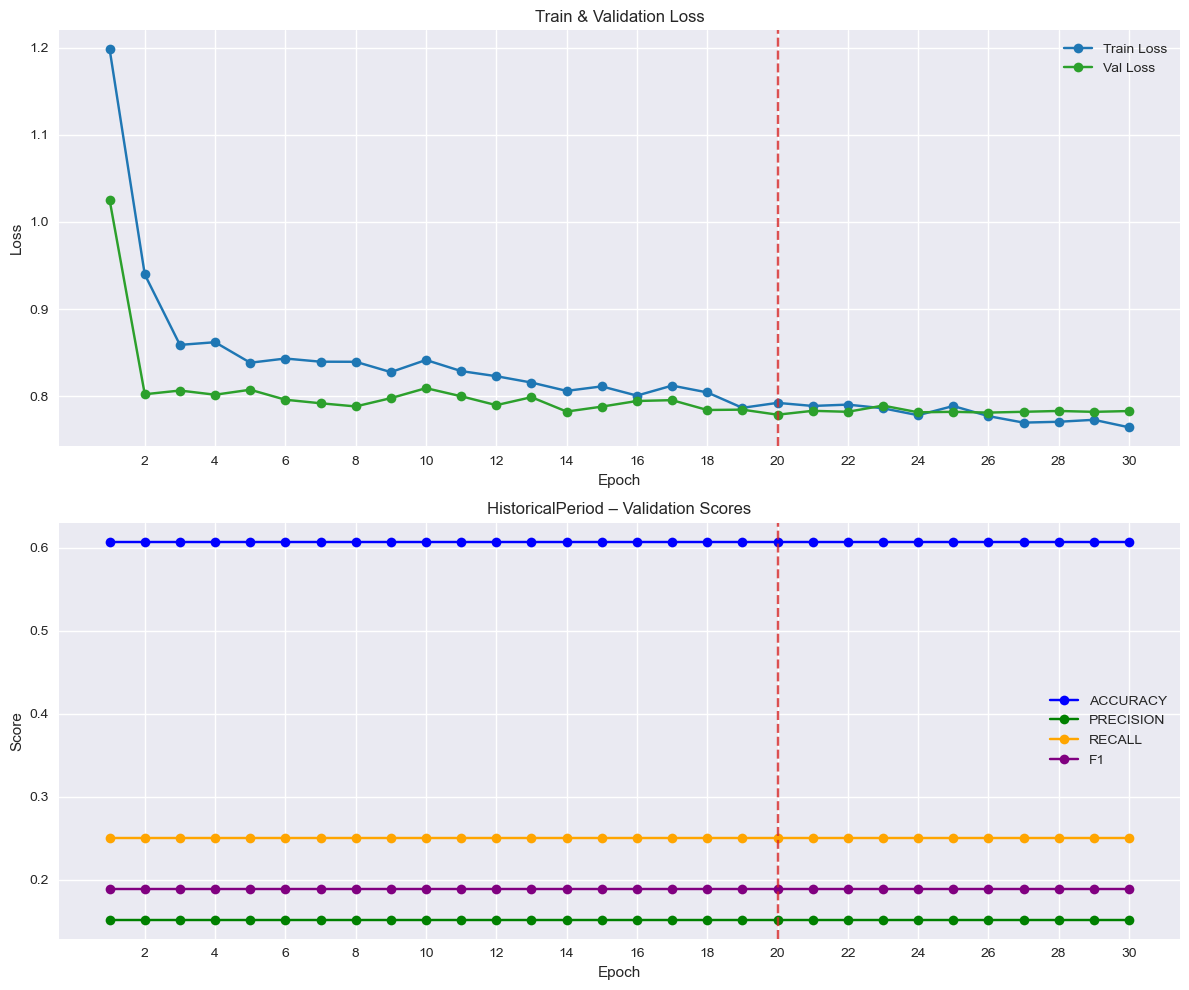



** FEATURE SET: RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 980.66it/s, loss=0.8246]


** Early stop | ran: 19/50 epochs | final: epoch 09 | train_loss: 0.6453, val_loss: 0.7399, accuracy: [0.64], precision: [0.31], recall: [0.29], f1: [0.28], 


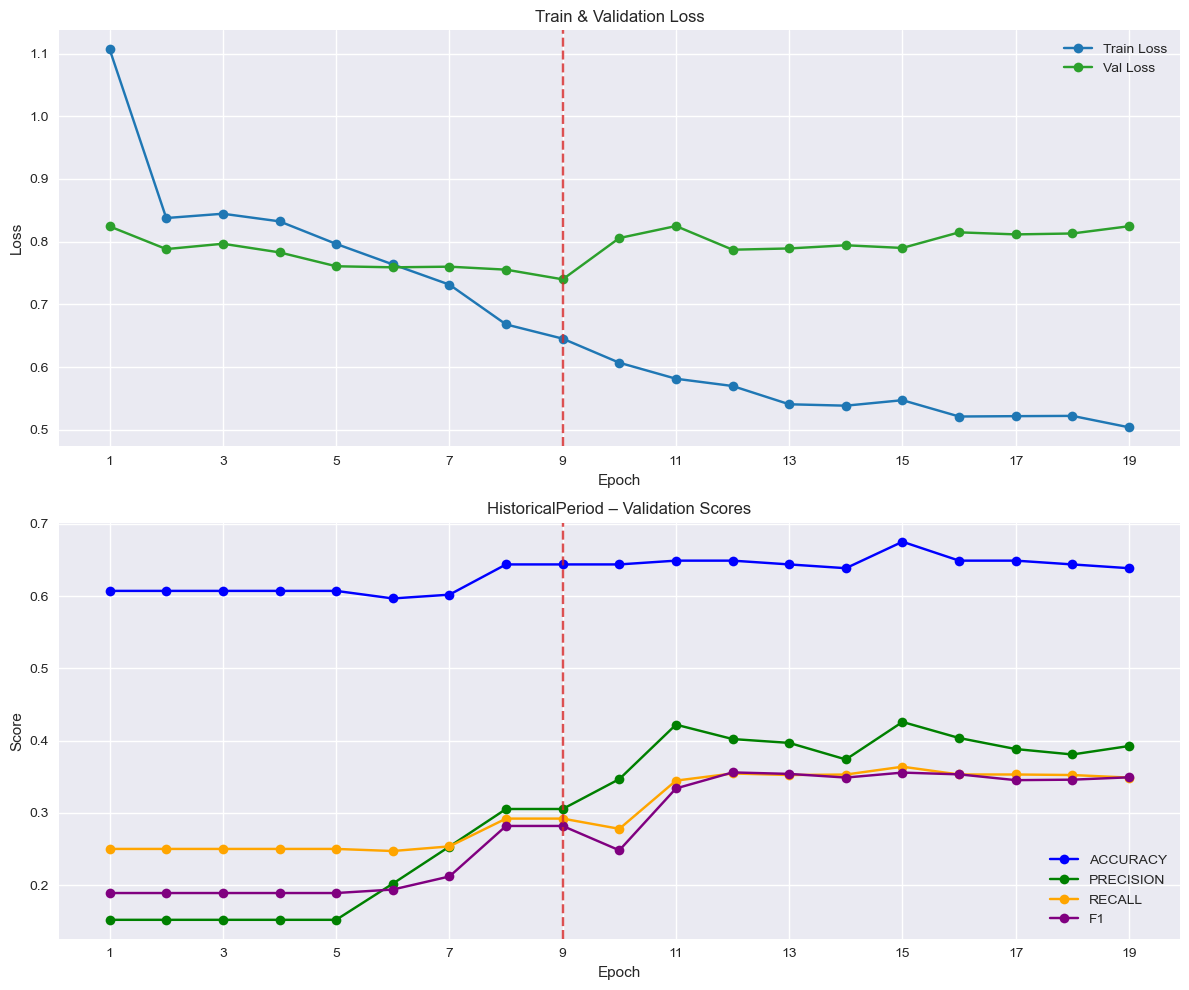



** FEATURE SET: VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 895.52it/s, loss=0.7522]


** Early stop | ran: 19/50 epochs | final: epoch 09 | train_loss: 0.6126, val_loss: 0.6678, accuracy: [0.68], precision: [0.48], recall: [0.43], f1: [0.43], 


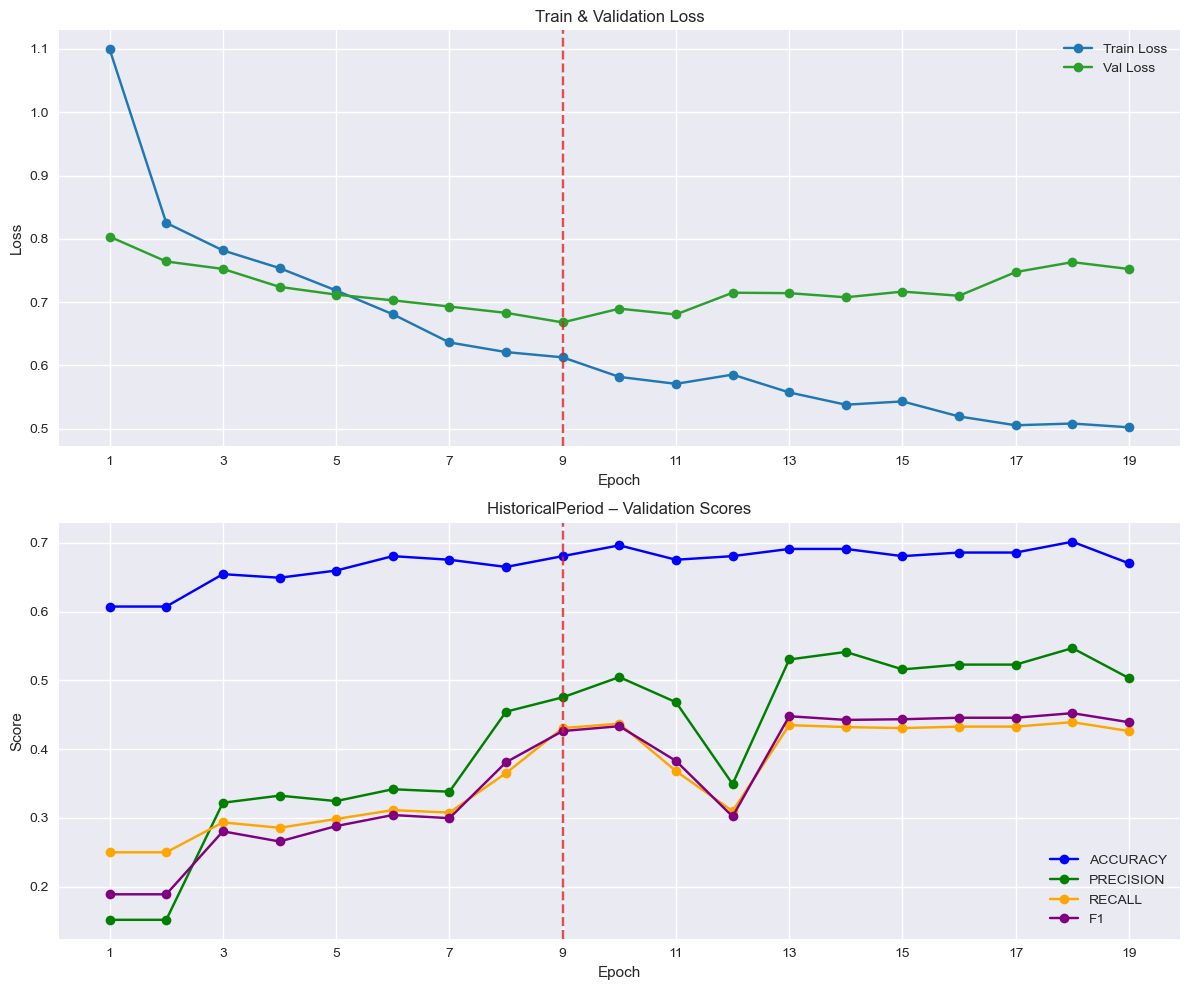



** FEATURE SET: TFIDF + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 803.92it/s, loss=0.9220]


** Early stop | ran: 16/50 epochs | final: epoch 06 | train_loss: 0.5336, val_loss: 0.5826, accuracy: [0.76], precision: [0.37], recall: [0.38], f1: [0.38], 


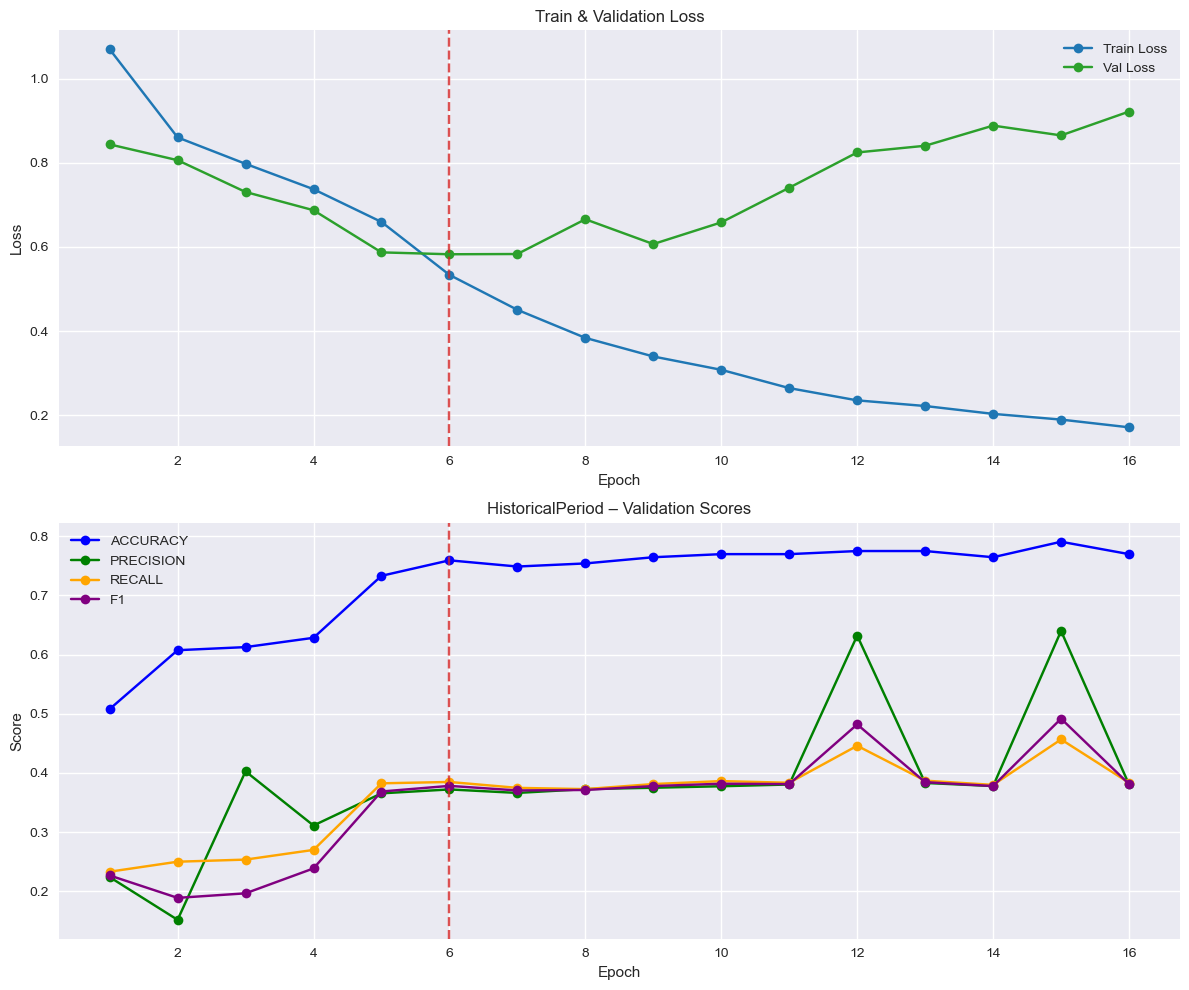



** FEATURE SET: TFIDF + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 862.85it/s, loss=1.0894]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.4512, val_loss: 0.5793, accuracy: [0.75], precision: [0.37], recall: [0.38], f1: [0.37], 


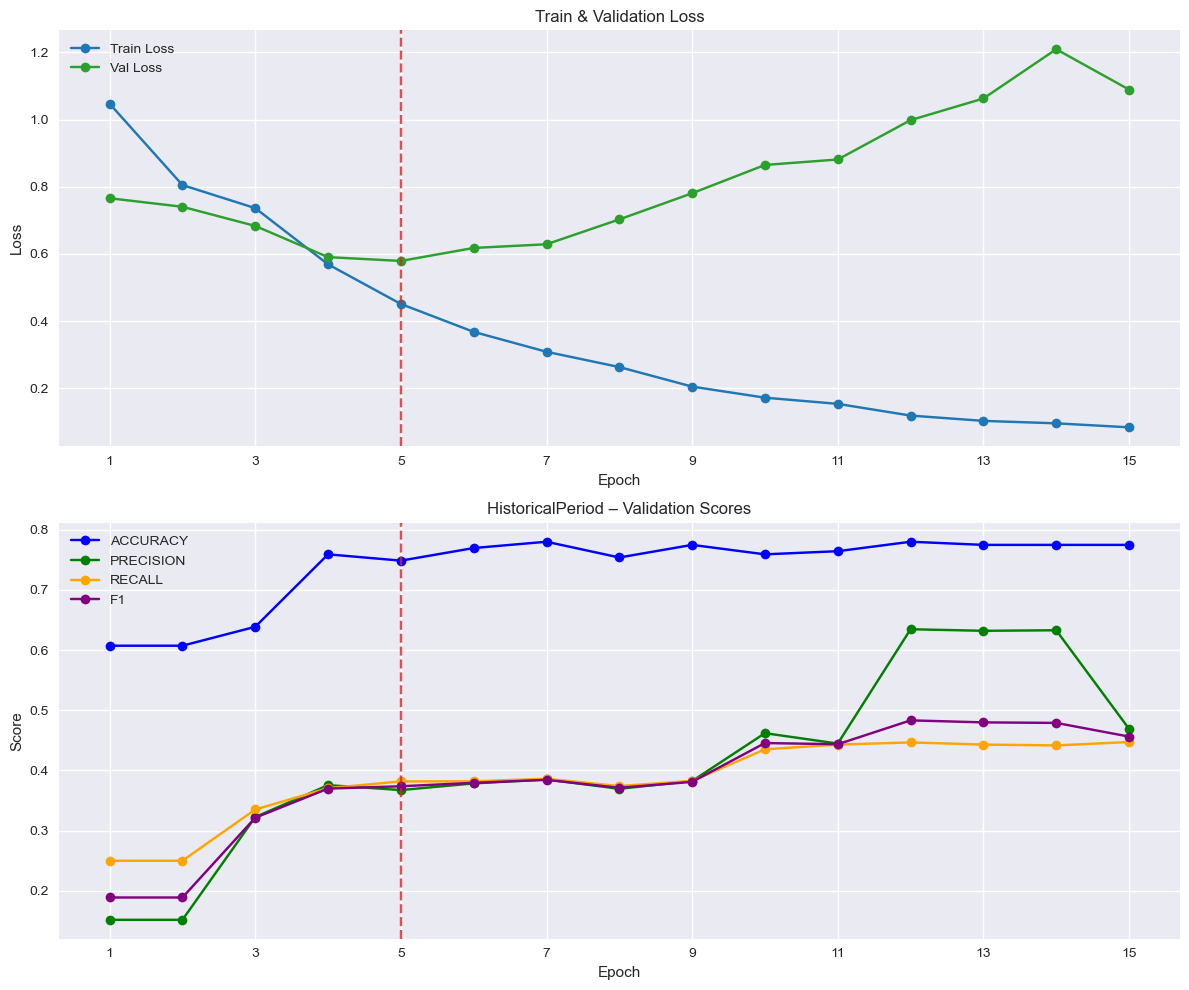



** FEATURE SET: TFIDF + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1255.53it/s, loss=1.1599]


** Early stop | ran: 16/50 epochs | final: epoch 06 | train_loss: 0.3891, val_loss: 0.5737, accuracy: [0.77], precision: [0.38], recall: [0.39], f1: [0.38], 


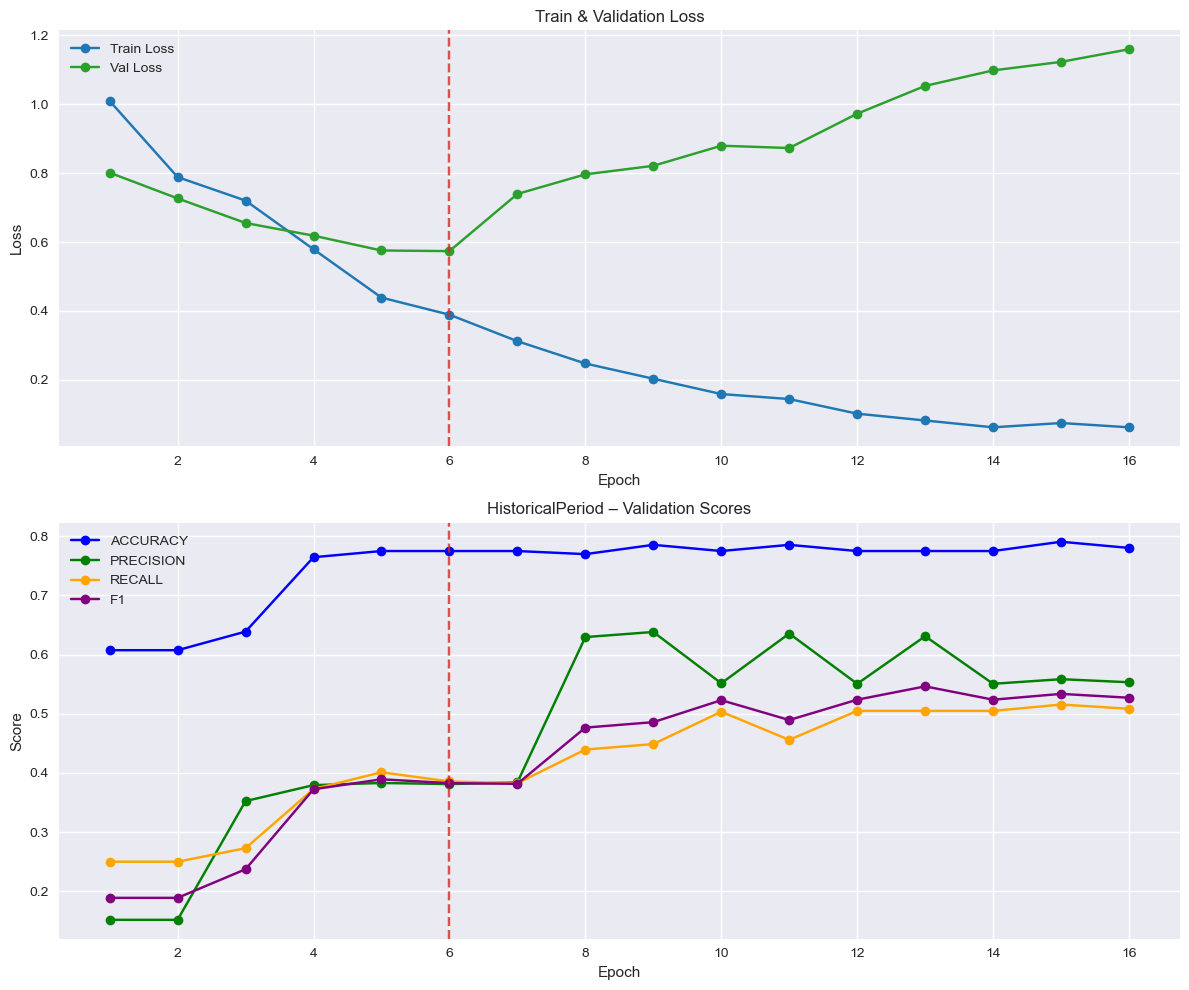



** FEATURE SET: BERT + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1001.66it/s, loss=0.8196]


** Early stop | ran: 31/50 epochs | final: epoch 21 | train_loss: 0.4844, val_loss: 0.6923, accuracy: [0.70], precision: [0.42], recall: [0.39], f1: [0.39], 


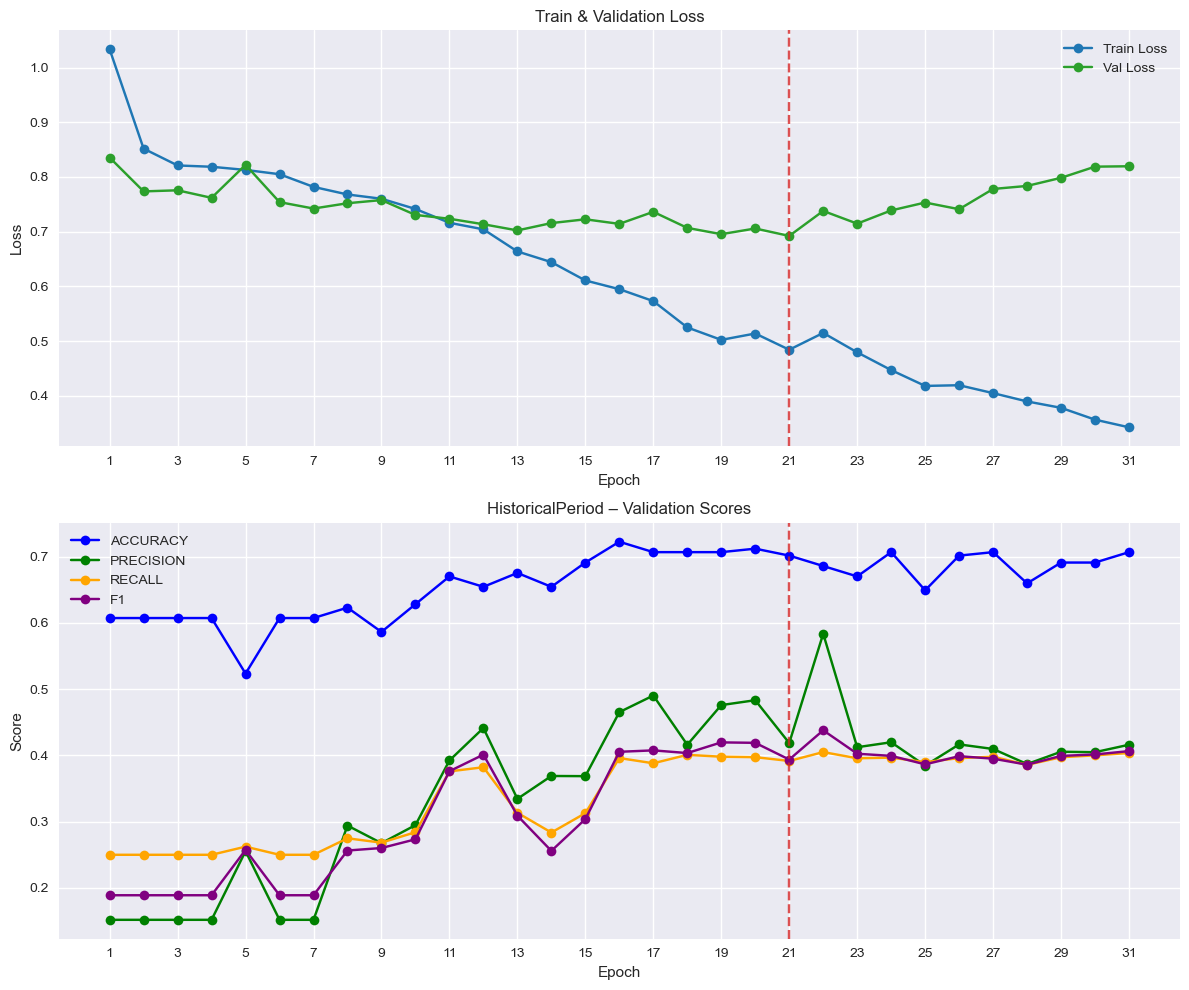



** FEATURE SET: BERT + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 862.91it/s, loss=0.8202]


** Early stop | ran: 18/50 epochs | final: epoch 08 | train_loss: 0.5538, val_loss: 0.6882, accuracy: [0.72], precision: [0.36], recall: [0.34], f1: [0.34], 


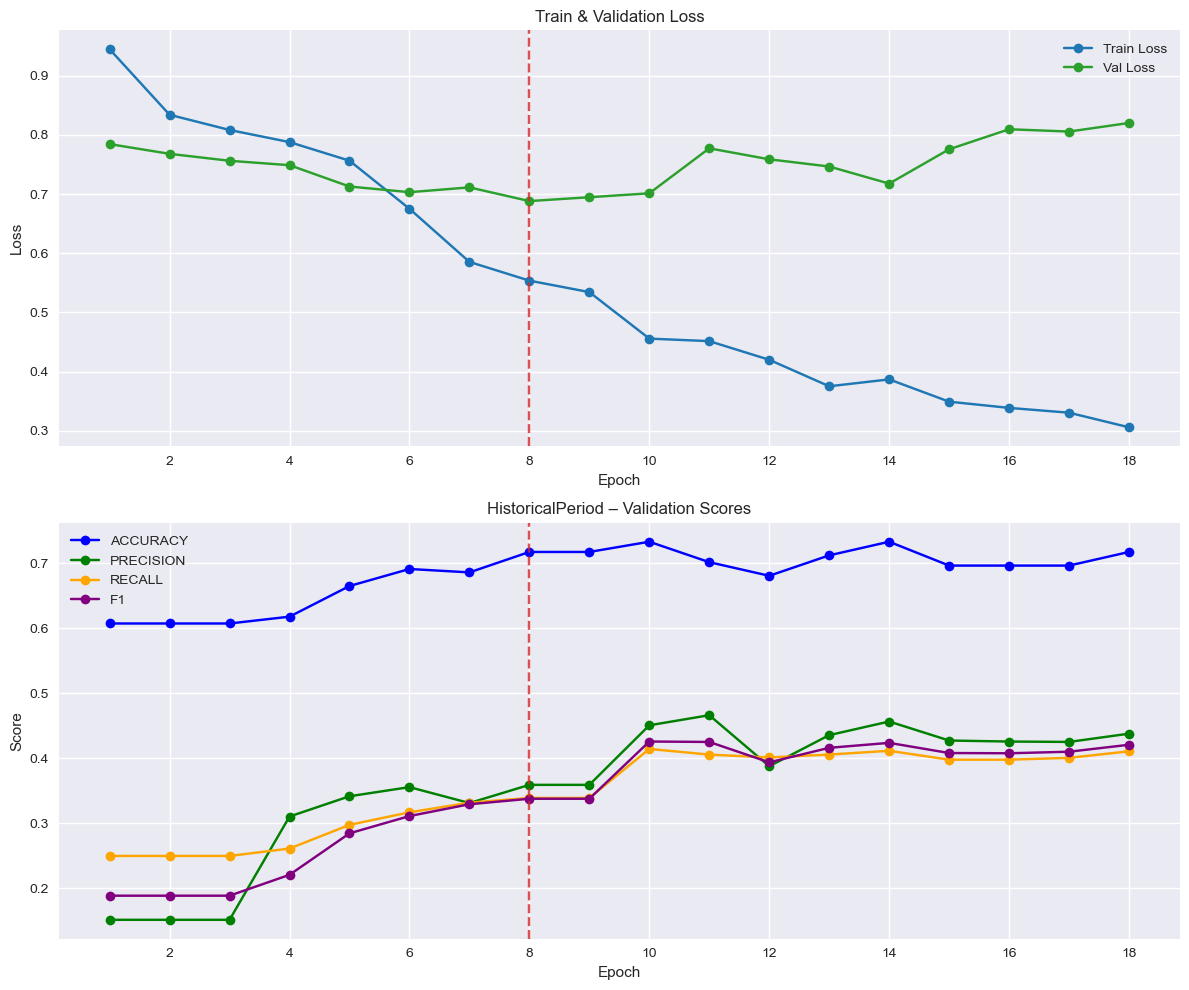



** FEATURE SET: BERT + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 998.80it/s, loss=0.8288]


** Early stop | ran: 18/50 epochs | final: epoch 08 | train_loss: 0.5360, val_loss: 0.6338, accuracy: [0.73], precision: [0.35], recall: [0.37], f1: [0.36], 


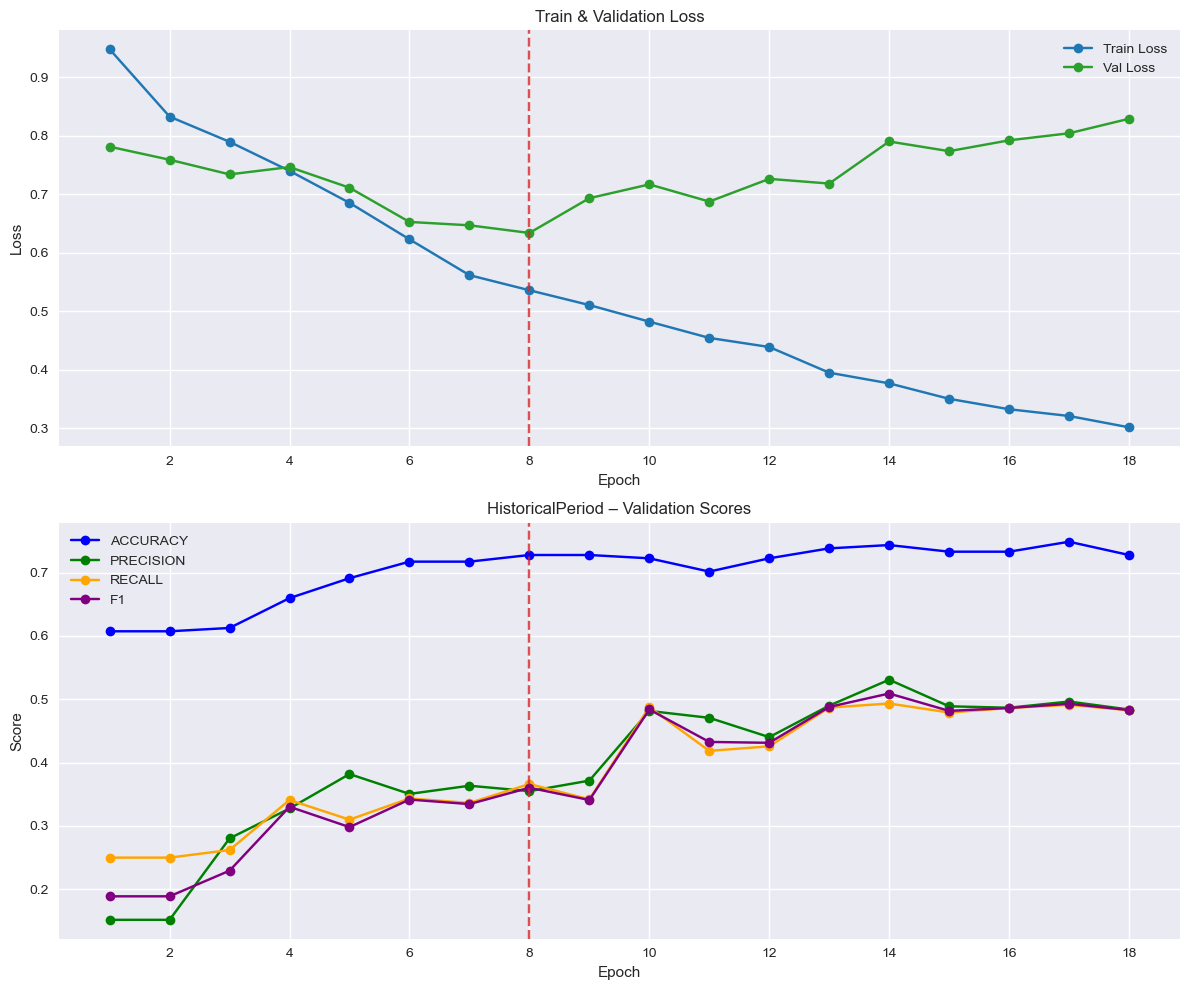

In [16]:
for ft, model in models.items():
    # if ft != "bert": continue
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, patience=10)
    plot_history(history, [target])